# Lens Modeling for DESIJ0132-1600

##### **Author(s)**: Fahim Rajit Hossain, Anowar J. Shajib
Acknowledgement: Anik Biswas, S M Rafee Adnan

### Importing libraries

In [3]:
import corner
import h5py
import joblib
import matplotlib.pyplot as plt
import numpy as np
import yaml
from google.colab import drive
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Util.param_util import (ellipticity2phi_q,
                                         shear_cartesian2polar)
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from light_profile import LightProfileAnalysis  # using light_profile.py

!pip install emcee
!pip install corner
!pip install cobaya
!pip install lenstronomy
!pip install ruff





%matplotlib inline

drive.mount("/content/drive")

Mounted at /content/drive


## Loading Data from h5 Files

In [4]:
with h5py.File("DESIJ0132-1600_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]


# load HDF5 psf file using h5py
with h5py.File("psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
kwargs_psf["psf_type"] = "PIXEL"


kwargs_data

{'background_rms': 0.015737876438598787,
 'dec_at_xy_0': -7.239999999999993,
 'exposure_time': array([[495.25476, 403.6011 , 453.53333, ..., 472.42017, 412.46506,
         489.70682],
        [412.80304, 515.1279 , 476.61252, ..., 476.53165, 445.4861 ,
         535.7192 ],
        [482.8193 , 496.1837 , 400.38693, ..., 357.60785, 298.3937 ,
         396.26035],
        ...,
        [441.2676 , 450.2588 , 376.2917 , ..., 236.26028, 390.93497,
         169.68163],
        [616.7411 , 419.57428, 460.05017, ..., 258.5865 , 227.25743,
         498.26813],
        [421.1636 , 456.823  , 494.05148, ..., 491.05872, 234.55467,
         349.67188]], dtype=float32),
 'image_data': array([[ 0.00430852,  0.00739825,  0.01483097, ...,  0.61809156,
          0.73717307,  1.03075923],
        [ 0.00502319, -0.03017073, -0.00753662, ...,  0.57677819,
          0.67688715,  0.79889763],
        [ 0.01126465,  0.0042542 ,  0.00804784, ...,  0.50703695,
          0.57667449,  0.61907252],
        ...,
   

<ipython-input-5-f44519a307c8>:8: RuntimeWarning: invalid value encountered in log10
  axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
<ipython-input-5-f44519a307c8>:11: RuntimeWarning: invalid value encountered in log10
  axes[1].imshow(np.log10(image), origin="lower", cmap="cubehelix")


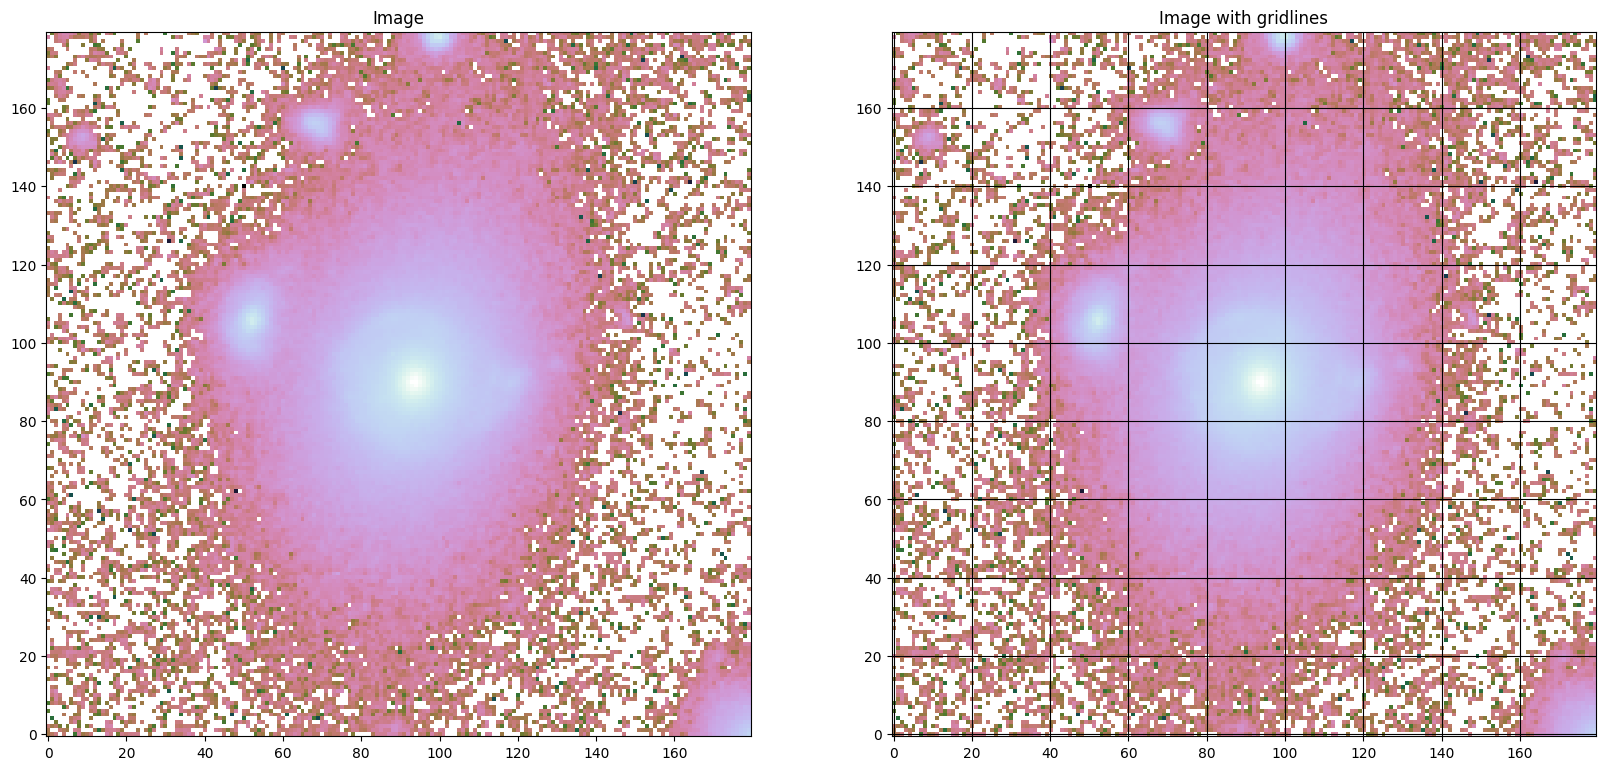

In [5]:
# extracting image_data from kwargs_data

image = kwargs_data["image_data"]

# Make the plot
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
axes[0].set_title("Image")

axes[1].imshow(np.log10(image), origin="lower", cmap="cubehelix")
axes[1].set_title("Image with gridlines")
axes[1].grid(True, color="black")

# Show the plots
plt.show()

## Creating Mask

In [6]:
# coordinate setup

ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

# Mask setup

r = 7.1  # arcsecond
# b = 4
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 3,
    lens_center_dec + 1.2,
    1.1,
    1.7,
    np.pi / 10,
)

mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.8,
    lens_center_dec + 5.1,
    0.7,
    0.7,
    0,
)
mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.7,
    lens_center_dec + 6.7,
    0.7,
    0.7,
    0,
)
mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 3.2,
    lens_center_dec + 0.23,
    0.3,
    0.3,
    0,
)

mask_ext_5 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.4,
    lens_center_dec - 0.1,
    0.25,
    0.25,
    0,
)


mask = (
    (1 - mask_outer)
    * (1 - mask_ext_1)
    * (1 - mask_ext_2)
    * (1 - mask_ext_3)
    * (1 - mask_ext_4)
    * (1 - mask_ext_5)
)
mask[mask >= 1] = 1
mask[mask < 0] = 0

mask_img_1 = mask.reshape(num_pix, num_pix)

### Setting the subplots


<ipython-input-7-4d2b903b9439>:3: RuntimeWarning: invalid value encountered in log10
  axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
<ipython-input-7-4d2b903b9439>:13: RuntimeWarning: divide by zero encountered in log10
  image_after_mask = np.log10(image * mask)
<ipython-input-7-4d2b903b9439>:13: RuntimeWarning: invalid value encountered in log10
  image_after_mask = np.log10(image * mask)


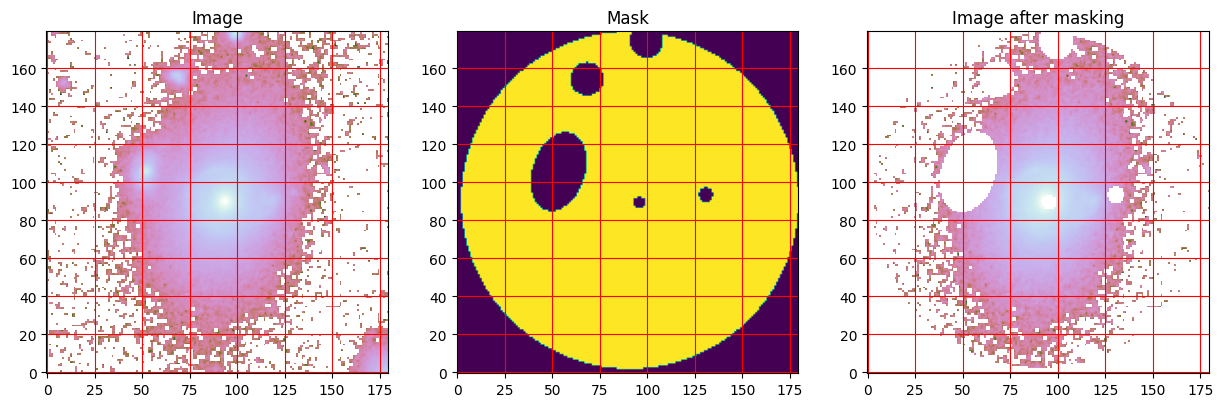

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 15))

axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
axes[0].grid(True, color="red")
axes[0].set_title("Image")

mask = mask.reshape(num_pix, num_pix)

axes[1].imshow(mask, origin="lower")
axes[1].grid(True, color="red")
axes[1].set_title("Mask")

image_after_mask = np.log10(image * mask)

axes[2].imshow(image_after_mask, origin="lower", cmap="cubehelix")
axes[2].grid(True, color="red")
axes[2].set_title("Image after masking")
# Show the plots
plt.show()

## Building a lens model

Here, we build a lens model. The lens model can be thought of three
components: the lens galaxy's mass model, the lens galaxy's light model, and
the source galaxy's light model. We have to give a list of profiles for each
 component as shown in the next codecell.

The `'EPL'` lens mass profile stands for Elliptical Power Law. The form of
this convergence profile is given by:
$$\kappa(x, y) = \frac{3 - \gamma}{2} \left[ \frac{\theta_{\rm E}}{\sqrt{q
x^2 + y^2 / q}} \right]^{\gamma - 1}. $$

The position angle $\phi$ adjusts the orientation of the mass profile's
major axis. The ellipticity parameters $q$ and $\phi$ can be reformulated as
$$e_1 = \frac{1 - q}{1 + q} \cos 2\phi,$$
$$e_2 = \frac{1 - q}{1 + q} \sin 2\phi.$$

`lenstronomy` uses $e_1$ and $e_2$ instead of $q$ and $\phi$, because $e_1$
and $e_2$ are easier to handle in numerical optimization, for example, in
MCMC. We checked [here](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/GettingStarted/units_coordinates_parameters_definitions.ipynb) for more details on
parameter definitions and conventions used in `lenstronomy`.


Both the lens galaxy's and the source galaxy's light profiles are modeled
with Sersic function, which is given by:

$$I(x, y) = I_{\rm e} \exp \left[ -b_{n} \left\{ \left( \frac{\sqrt{qx^2
+ y^2/q}}{R_{\rm Sersic}} \right)^{1/n_{\rm Sersic}} - 1 \right\}
\right].$$

## Lens Modeling with Lenstronomy

In [8]:
lens_model_list = ["EPL", "SHEAR"]
source_model_list = ["SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

## Lens Galaxy's Mass Model

### EPL Parameters

In [9]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []


fixed_lens.append({"gamma": 2})
kwargs_lens_init.append(
    {
        "theta_E": 1.4,
        "gamma": 2,
        "e1": -0.0749,
        "e2": -0.12077,
        "center_x": -0.2102,
        "center_y": -0.0083,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.1,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 1,
        "gamma": 1.7,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 2.1,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)

### SHEAR profile Parameters

In [10]:
fixed_lens.append({"ra_0": 0, "dec_0": 0})


kwargs_lens_init.append({"gamma1": 0.066, "gamma2": -0.00263})
kwargs_lens_sigma.append({"gamma1": 0.01, "gamma2": 0.01})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3})

lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

## Source Galaxy's Light Model

### Sersic Ellipse Parameters

In [ ]:
"""
fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "R_sersic": 0.002,
        "n_sersic": 1,
        "e1": 0.9960,
        "e2": -0.1501,
        "center_x": -0.5247,
        "center_y": -0.0455,
        "amp": 1,
    }
)
kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.001,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 1,
    }
)
kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_source.append(
    {
        "e1": 1,
        "e2": 1,
        "R_sersic": 0.2,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)
"""

'\nfixed_source.append({"n_sersic": 1.0})\nkwargs_source_init.append(\n    {\n        "R_sersic": 0.002,\n        "n_sersic": 1,\n        "e1": 0.9960,\n        "e2": -0.1501,\n        "center_x": -0.5247,\n        "center_y": -0.0455,\n        "amp": 1,\n    }\n)\nkwargs_source_sigma.append(\n    {\n        "n_sersic": 0.5,\n        "R_sersic": 0.001,\n        "e1": 0.05,\n        "e2": 0.05,\n        "center_x": 0.2,\n        "center_y": 0.2,\n        "amp": 1,\n    }\n)\nkwargs_lower_source.append(\n    {\n        "e1": -0.5,\n        "e2": -0.5,\n        "R_sersic": 0.001,\n        "n_sersic": 0.5,\n        "center_x": -10,\n        "center_y": -10,\n        "amp": 0,\n    }\n)\nkwargs_upper_source.append(\n    {\n        "e1": 1,\n        "e2": 1,\n        "R_sersic": 0.2,\n        "n_sersic": 5.0,\n        "center_x": 10,\n        "center_y": 10,\n        "amp": 100,\n    }\n)\n'

### Shapelets Profile Parameters

In [11]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


fixed_source.append({"n_max": 10})

kwargs_source_init.append({"center_x": -0.5522, "center_y": 0.045511, "beta": 0.07})
kwargs_source_sigma.append({"center_x": 0.2, "center_y": 0.2, "beta": 0.001})
kwargs_lower_source.append({"center_x": -10, "center_y": -10, "beta": 0.001})
kwargs_upper_source.append({"center_x": 10, "center_y": 10, "beta": 0.2})

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

# joint_shapelets_with_sersic = [[0, 1, ["center_x", "center_y"]]]

## Lens Galaxy's Light Model

### 1st Sersic Ellipse Parameters

In [12]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({"n_sersic": 1.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 1.8705,
        "n_sersic": 2,
        "e1": -0.1897,
        "e2": -0.115,
        "center_x": -0.255,
        "center_y": -0.0594,
        "amp": 16,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

### 2nd Sersic Ellipse Parameters

In [13]:
fixed_lens_light.append({"n_sersic": 4.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 0.5280,
        "n_sersic": 2,
        "e1": -0.0355,
        "e2": -0.0266,
        "center_x": -0.2554,
        "center_y": -0.059,
        "amp": 16,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y", "e1", "e2"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]

### Combining all the above specification in the `kwargs_params` dictionary

In [14]:
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
    # "joint_source_with_source": joint_shapelets_with_sersic,
}

### Numerical settings

In [16]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask]}

kwargs_numerics = {"supersampling_factor": 3, "supersampling_convolution": False}

#### Combining all the information to be sent to lenstronomy

In [17]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band"
    # 'multi-linear': every imaging band
    # has independent solutions of the
    # surface brightness, 'joint-linear':
    # there is one joint solution of the
    # linear coefficients demanded across the bands.
}

## The Model Fitting

In [ ]:
# using Particle Swarm Optimization

fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 100, "n_iterations": 100}]
]

fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    mpi=False,
    verbose=True,
)

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
]

fit_output = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list

kwargs_fixed_out = fitting_seq._updateManager.fixed_kwargs
output = [
    kwargs_result,
    multi_band_list_out,
    fit_output,
    kwargs_fixed_out,
]

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-0.8176423928618277 reduced X^2 of best position
-9498.551677875852 log likelihood
23234 effective number of data points
[{'theta_E': 1.3996970750354234, 'gamma': 2, 'e1': -0.09276902553348466, 'e2': -0.13040146274483744, 'center_x': -0.19490807604131655, 'center_y': -0.030479443833097728}, {'gamma1': 0.057951424725340095, 'gamma2': -0.00560052273750782, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.0031514938488777645, 'n_sersic': 1.0, 'e1': 0.9675261457715572, 'e2': -0.16720427288749926, 'center_x': -0.48992966561225065, 'center_y': 0.01840366767547679}, {'amp': 1, 'n_max': 10, 'beta': 0.09998238043616739, 'center_x': -0.48992966561225065, 'center_y': 0.01840366767547679}] source result
[{'amp': 1, 'R_sersic': 1.9082223651423162, 'n_sersic': 1.0, 'e1': -0.19830796041993198, 'e2': -0.11700128808635486, 'center_x': -0.2703539620705419, 'center_y': -0.059481218766267836}, {'amp': 1, 'R_

In [ ]:
output_path = "./DESIJ0132-1600_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

## Visualizing the Fitted Model

-0.8144873673362932 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.8144873673362932


<ipython-input-35-8b2e6c634728>:20: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


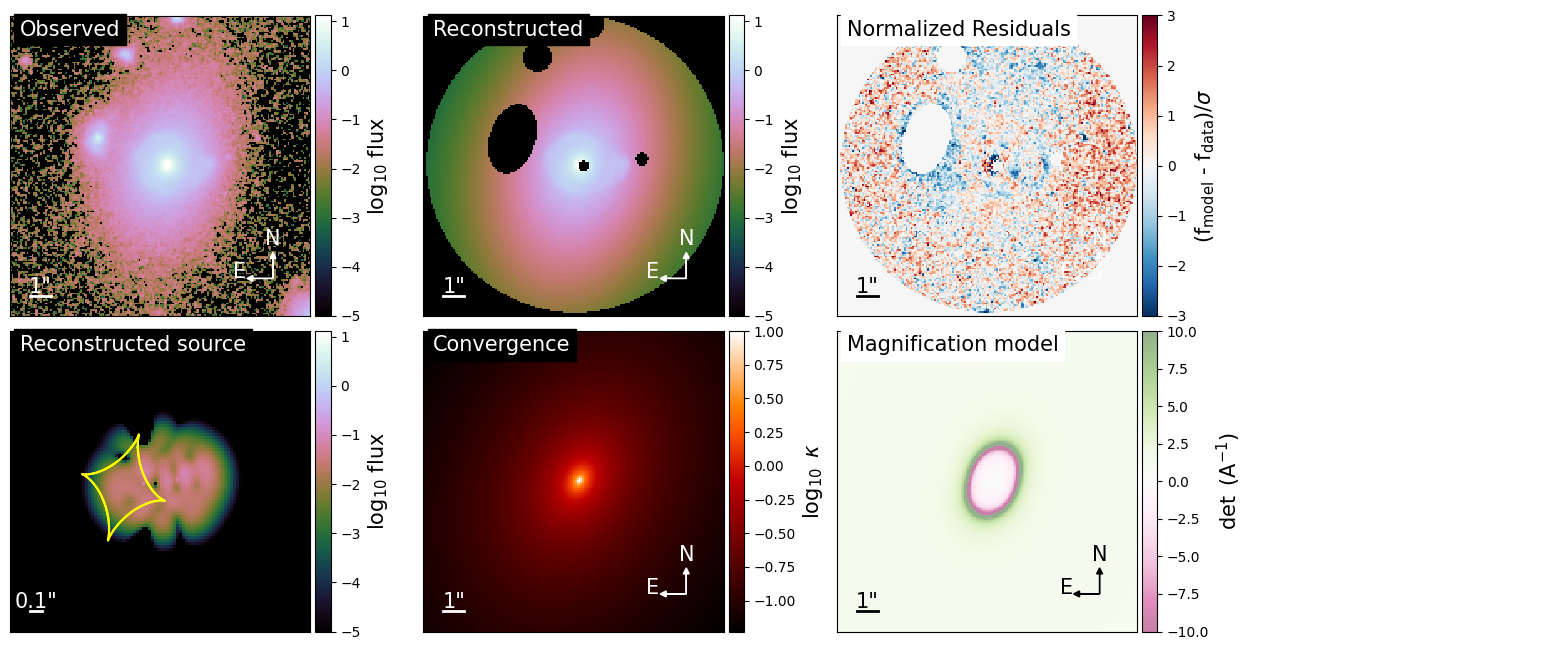

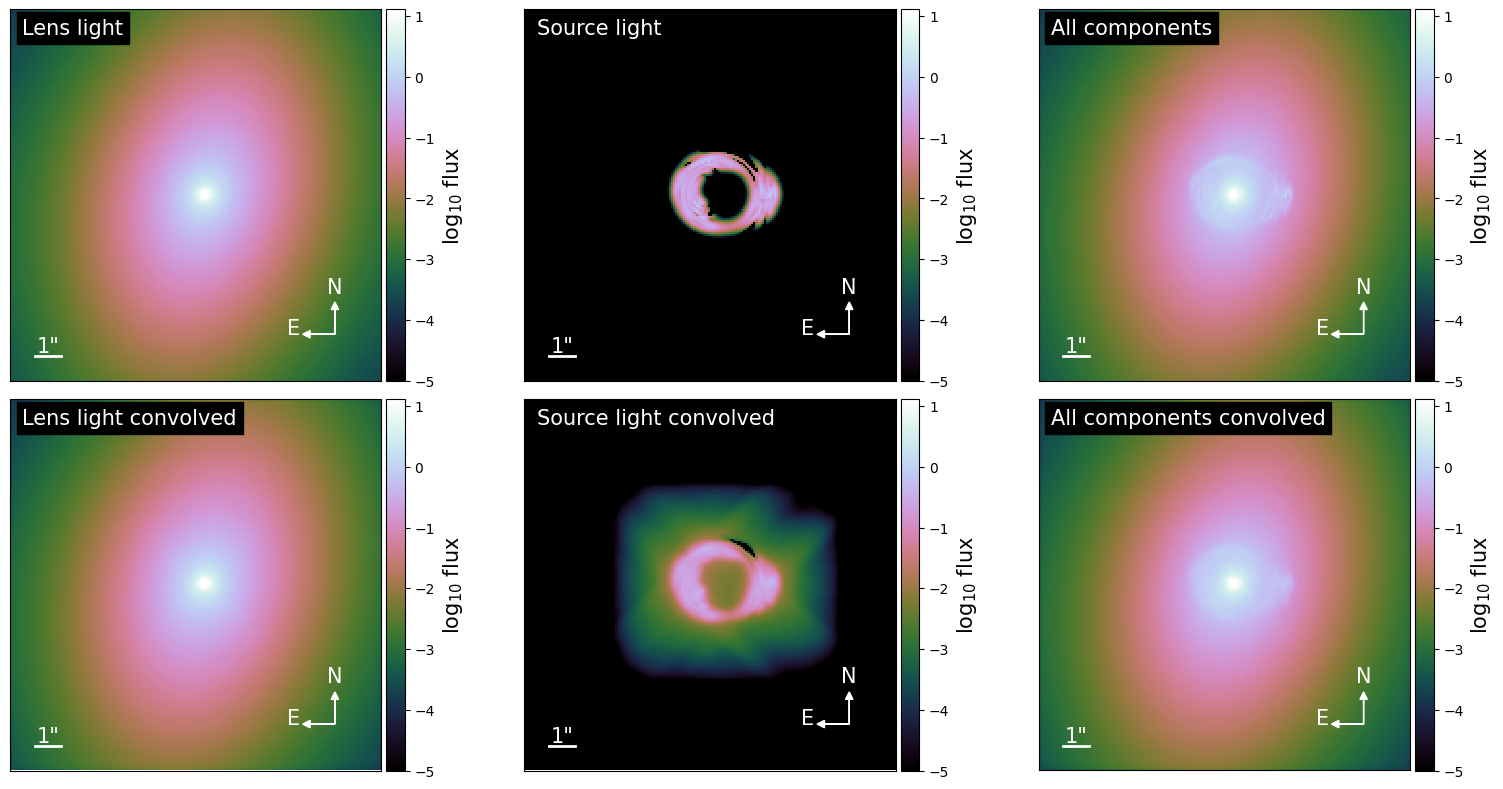

In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.025, numPix=100, with_caustics=True
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

## *running MCMC*

In [18]:
# Define the path to the file on Google Drive
mcmc11_backend = "/content/drive/MyDrive/BDLensing/mcmc11_backend.h5"


fitting_kwargs_list_mcmc = [
    [
        "MCMC",
        {
            "n_burn": 0,
            "n_run": 1,
            "n_walkers": 80,
            "sigma_scale": 0.1,
            "backend_filename": mcmc11_backend,
            "start_from_backend": True,
        },
    ]
]


fitting_seq_mcmc = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

chain_list_mcmc = fitting_seq_mcmc.fit_sequence(fitting_kwargs_list_mcmc)
kwargs_result_mcmc = fitting_seq_mcmc.best_fit()

MCMC selected. Sampling with default option emcee.


100%|██████████| 1/1 [01:17<00:00, 77.23s/it]

Computing the MCMC...
Number of walkers =  80
Burn-in iterations:  0
Sampling iterations (in current run): 1
79.46976113319397 time taken for MCMC sampling


In [19]:
if len(chain_list_mcmc) > 0:
    for i, chain in enumerate(chain_list_mcmc):
        print(f"Chain {i + 1}:")
        print("Sampler type:", chain[0])
        print("Parameter names:", chain[2])
        print("Shape of samples:", chain[1].shape)
        print("")

    # Alternatively, you can access the last chain directly

    last_chain = chain_list_mcmc[-1]
    last_samples = last_chain[1]
    last_param_names = last_chain[2]
    print("Last Chain:")
    print("Sampler type:", last_chain[0])
    print("Parameter names:", last_param_names)
    print("Shape of samples:", last_samples.shape)
else:
    print("No MCMC chains available.")

Chain 1:
Sampler type: emcee
Parameter names: ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'beta_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1']
Shape of samples: (176160, 16)

Last Chain:
Sampler type: emcee
Parameter names: ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'beta_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1']
Shape of samples: (176160, 16)


## Visualizing the MCMC chain

<ipython-input-20-4f3beb81838c>:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


N_step: 2202, N_walkers: 80, N_params: 16
theta_E_lens0 1.4036 ± 0.0058
e1_lens0 -0.1781 ± 0.0146
e2_lens0 -0.0733 ± 0.0157
center_x_lens0 -0.1498 ± 0.0092
center_y_lens0 0.0413 ± 0.0076
gamma1_lens1 -0.0063 ± 0.0074
gamma2_lens1 0.0250 ± 0.0080
beta_source_light0 0.1997 ± 0.0004
center_x_source_light0 -0.2398 ± 0.0120
center_y_source_light0 0.0156 ± 0.0127
R_sersic_lens_light0 1.8094 ± 0.0078
e1_lens_light0 -0.1433 ± 0.0012
e2_lens_light0 -0.0865 ± 0.0015
center_x_lens_light0 -0.2622 ± 0.0008
center_y_lens_light0 -0.0522 ± 0.0006
R_sersic_lens_light1 0.3166 ± 0.0085


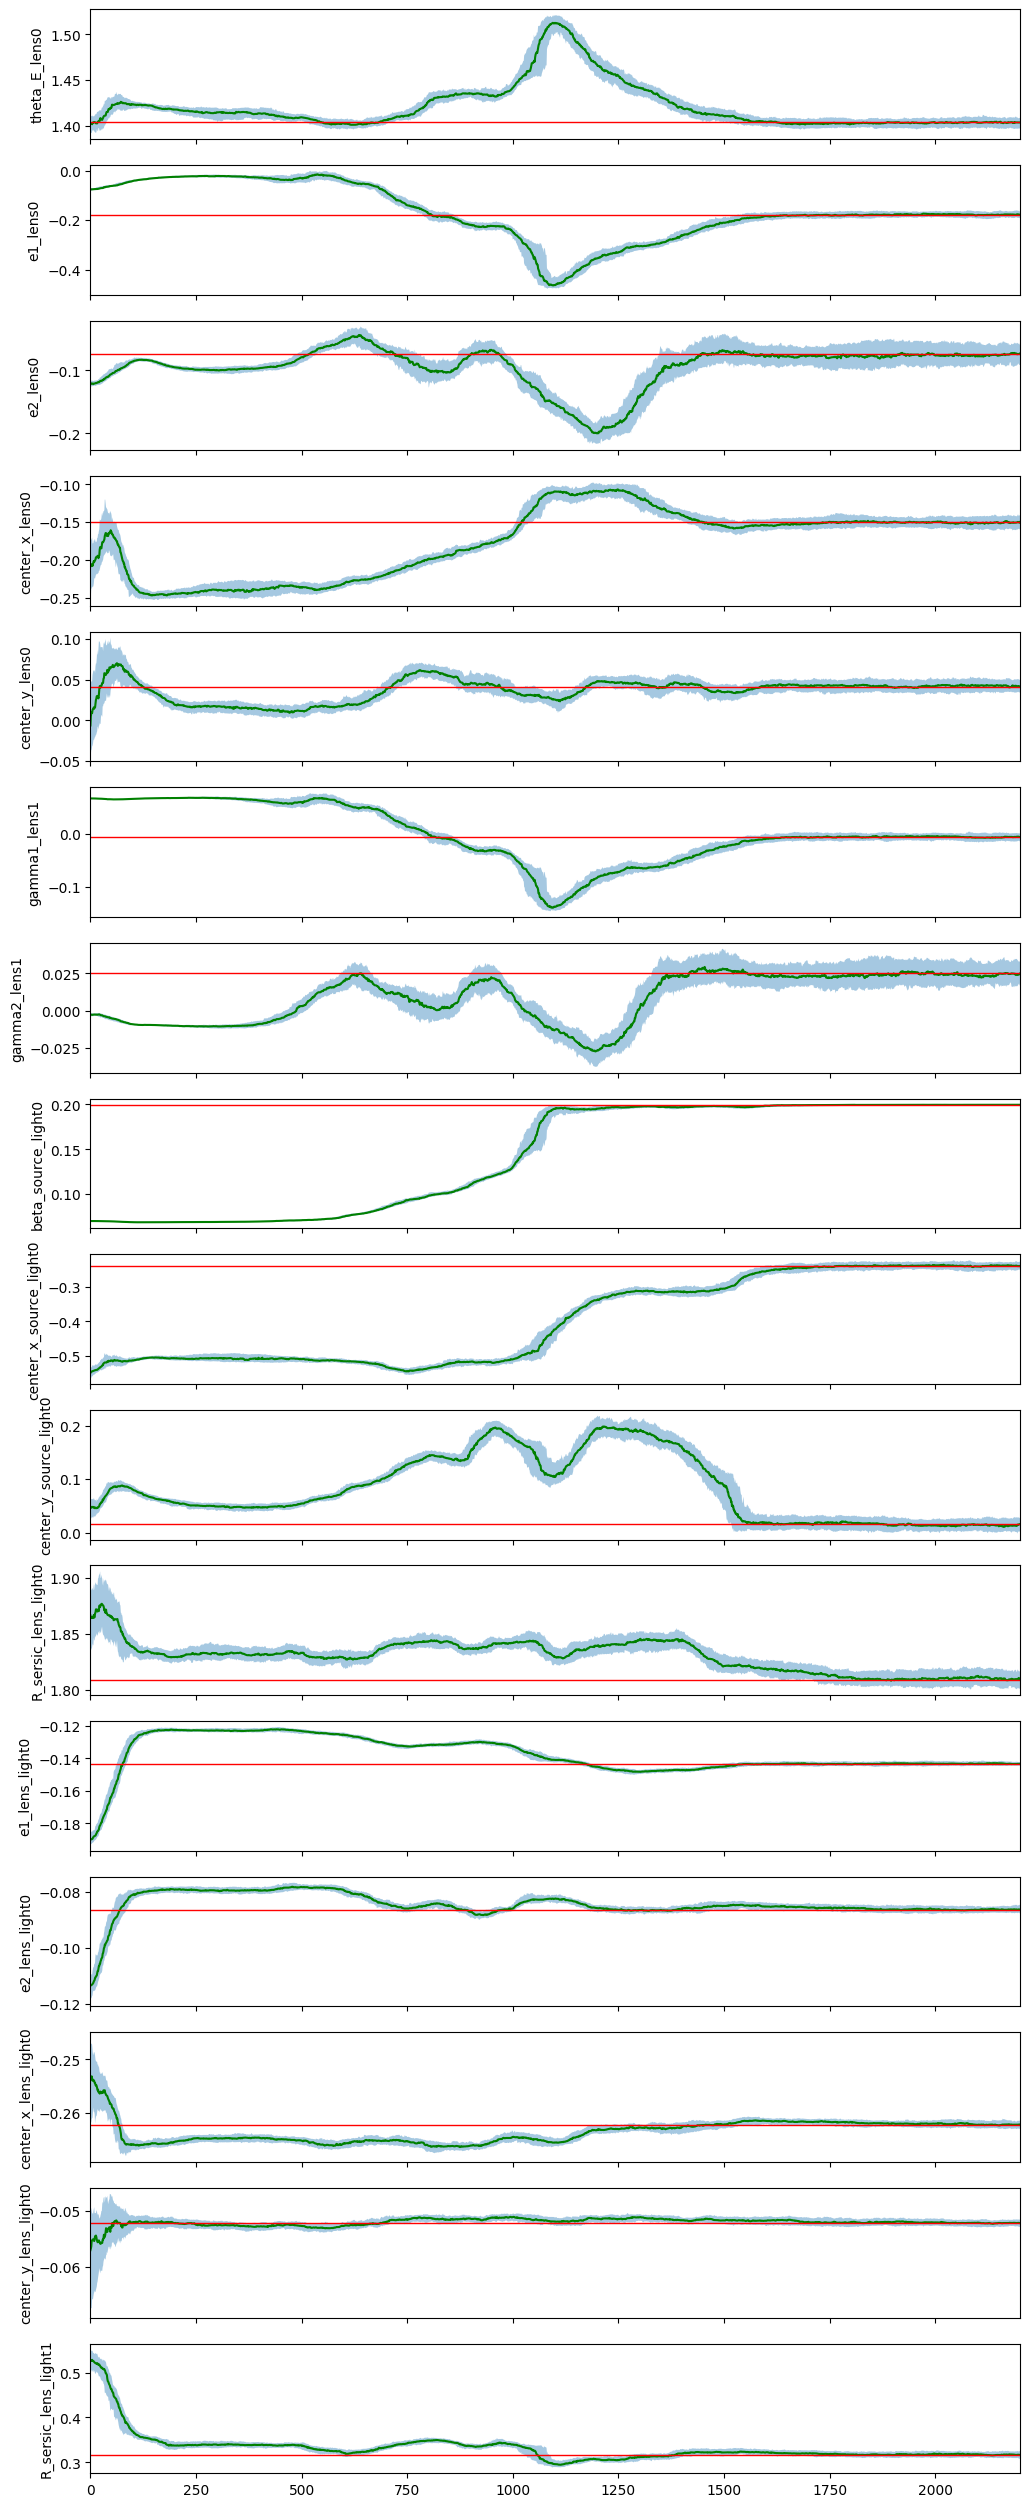

In [20]:
# Traceplot

samples_mcmc = []

if chain_list_mcmc[-1][0] != "PSO":
    # if MCMC chain was broken in the chunks,
    # we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc) - mcmc_repeat, len(chain_list_mcmc)):
        samples_mcmc = chain_list_mcmc[k][1]

        param_mcmc = chain_list_mcmc[k][2]

if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]

    n_walkers = 80  # Adjust the walker ratio as needed
    n_step = int(samples_mcmc.shape[0] / n_walkers)  #

    print("N_step: {}, N_walkers: {}, N_params: {}".format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in range(n_params):
        samples = samples_mcmc[:, i]
        reshaped_samples = samples.reshape((n_walkers, n_step), order="F")
        chain[:, :, i] = reshaped_samples

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in range(n_params):
        for j in range(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.0)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.0)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [
        median_pos[0][last - 1],
        (q84_pos[0][last - 1] - q16_pos[0][last - 1]) / 2,
        median_pos[1][last - 1],
        (q84_pos[1][last - 1] - q16_pos[1][last - 1]) / 2,
    ]

    for i in range(n_params):
        print(
            param_mcmc[i],
            "{:.4f} ± {:.4f}".format(
                median_pos[i][last - 1],
                (q84_pos[i][last - 1] - q16_pos[i][last - 1]) / 2,
            ),
        )

        ax[i].plot(median_pos[i][:last], c="g")
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c="r", lw=1)
        ax[i].fill_between(
            np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4
        )
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12.0, 2 * len(param_mcmc)))
        plt.show()

## Corner Plot

Number of non-linear parameters in the MCMC process: 16
Parameters in order: ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'beta_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1']
Number of evaluations in the MCMC process: 176160
176160
Shape of samples_mcmc_cut: (10080, 16)


<ipython-input-21-0700cfc424c6>:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc_cut == []:


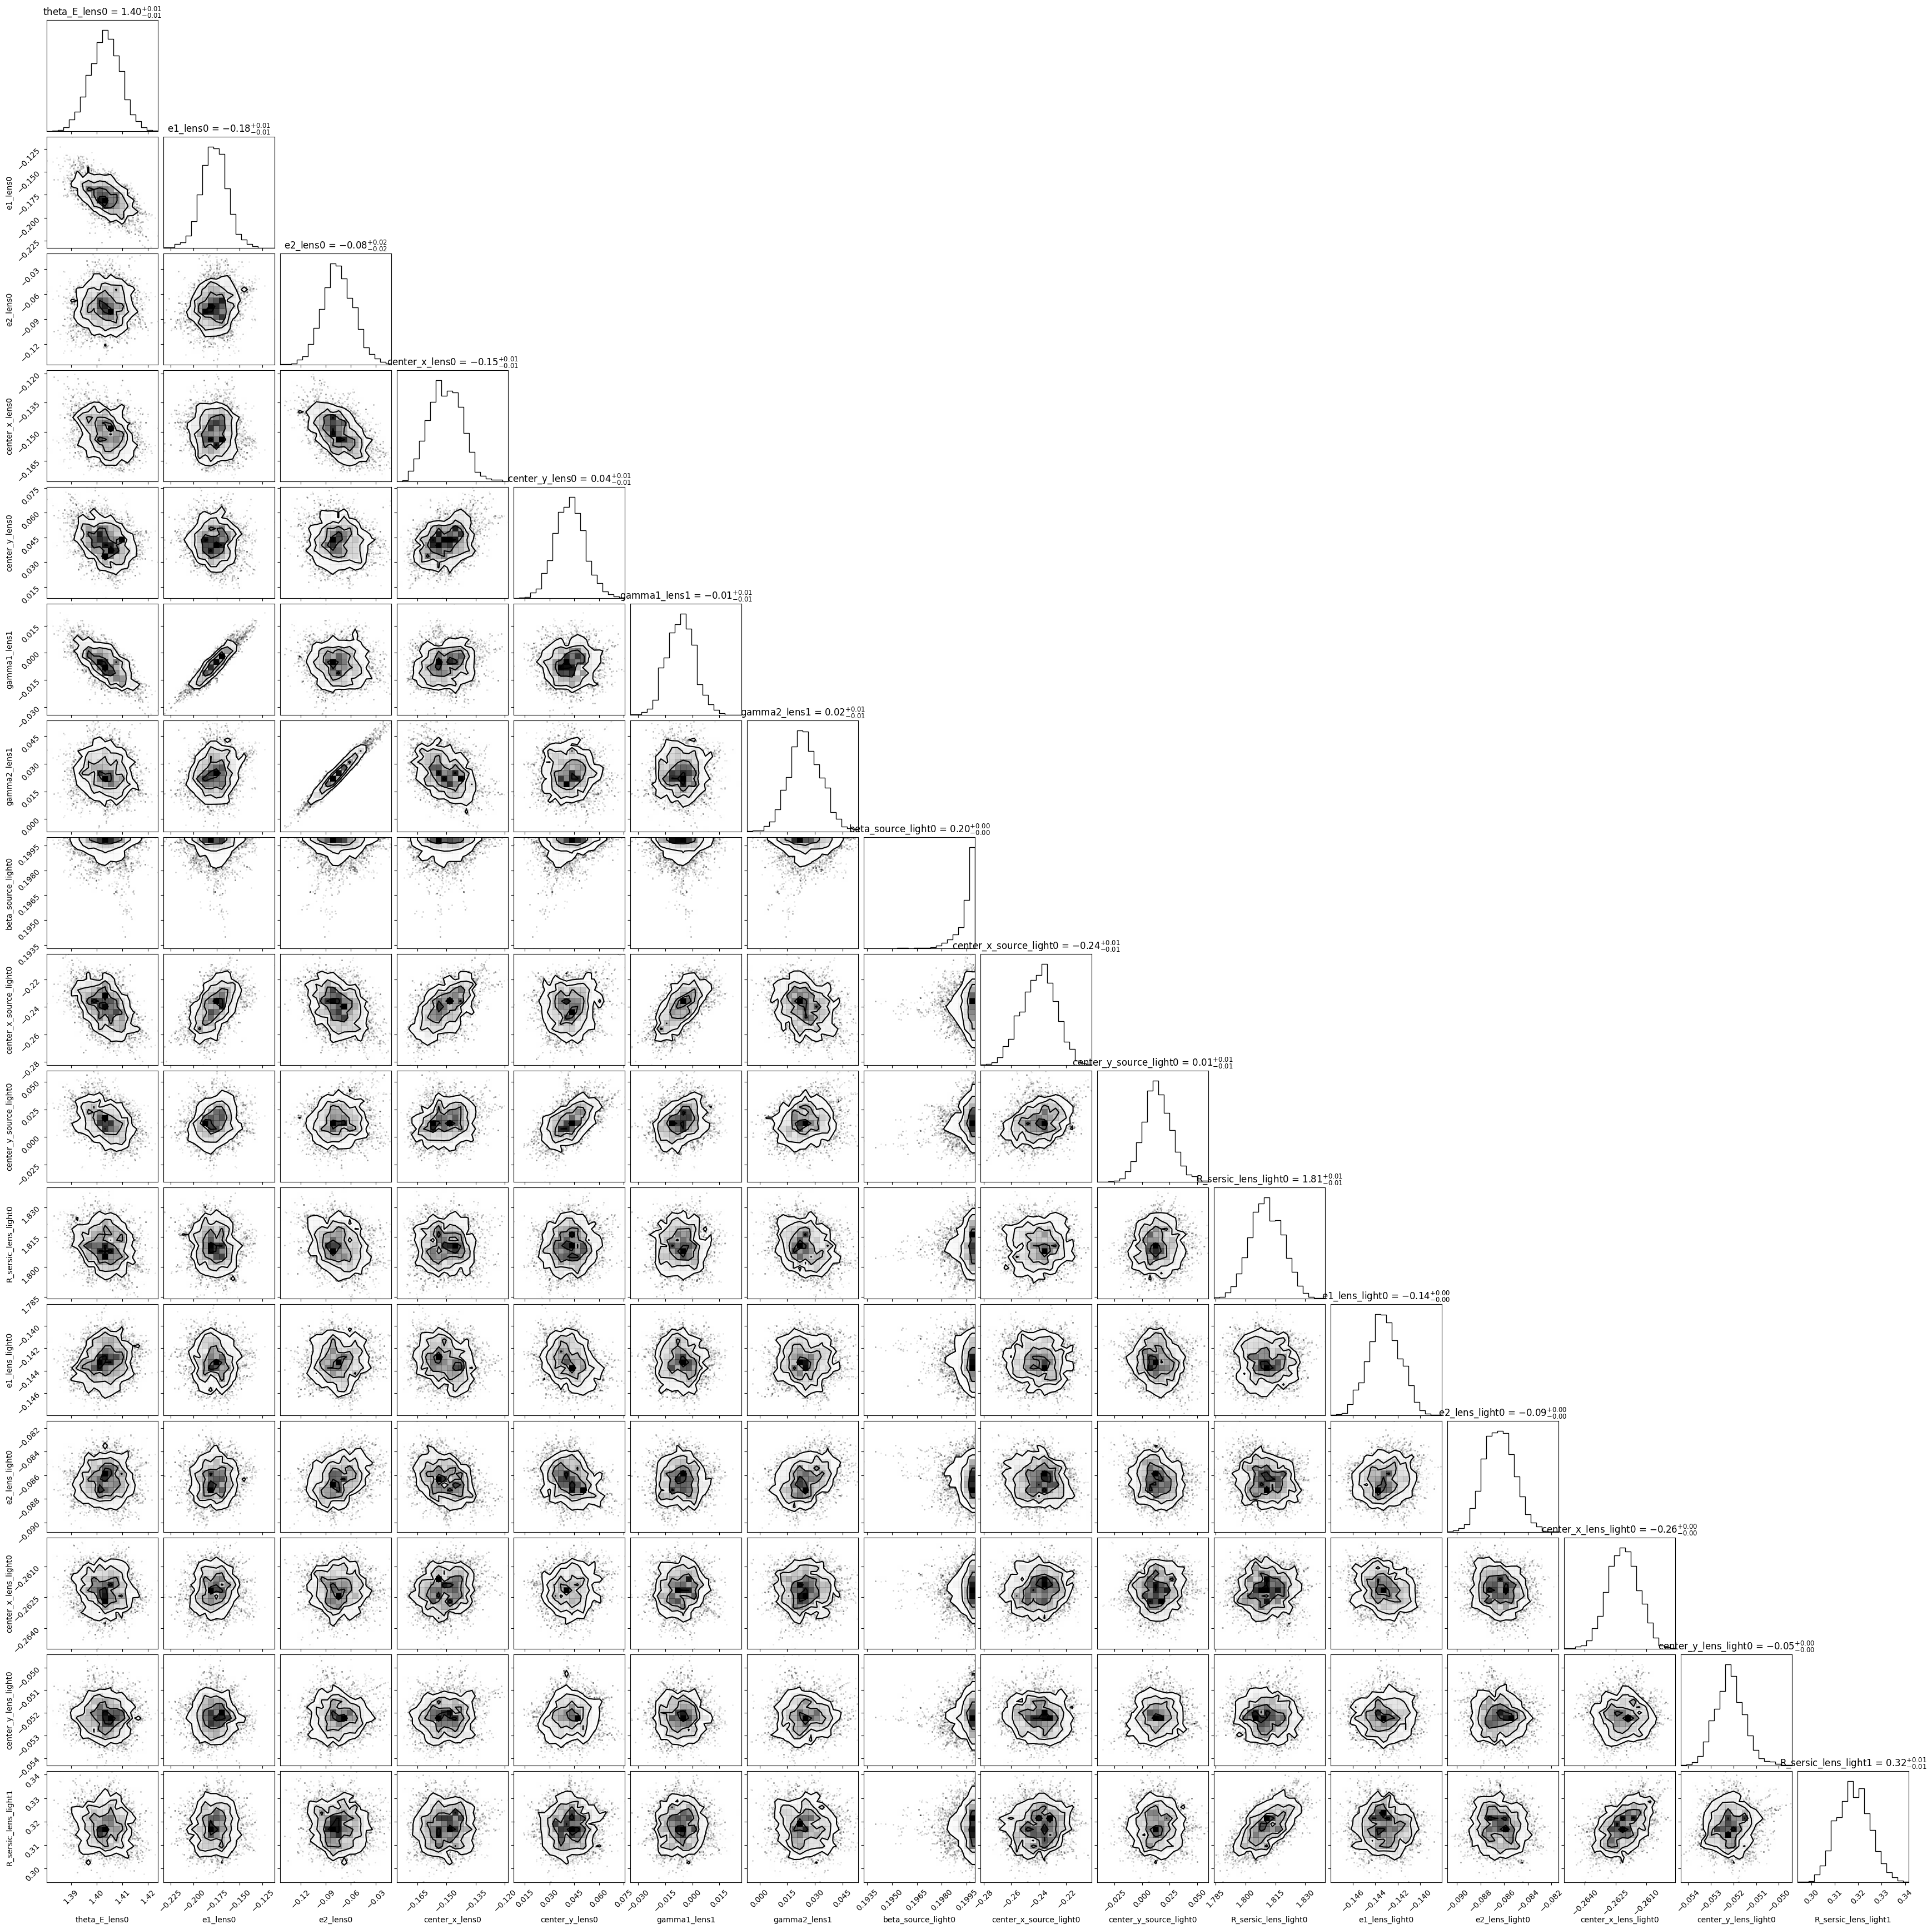

In [21]:
if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq_mcmc.param_class

    print("Number of non-linear parameters in the MCMC process:", len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        burnin = 1950
        thin = 2
        samples_mcmc_cut = chain[:, burnin::thin, :].reshape((-1, n_params))
        if not samples_mcmc_cut == []:
            n, num_param = np.shape(samples_mcmc_cut)
            print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
            plot = corner.corner(samples_mcmc_cut, labels=param_mcmc, show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")

## Visualizing the fitted model with `MCMC`

-0.8682277399345399 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.8682277399345397


/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:156: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:219: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),


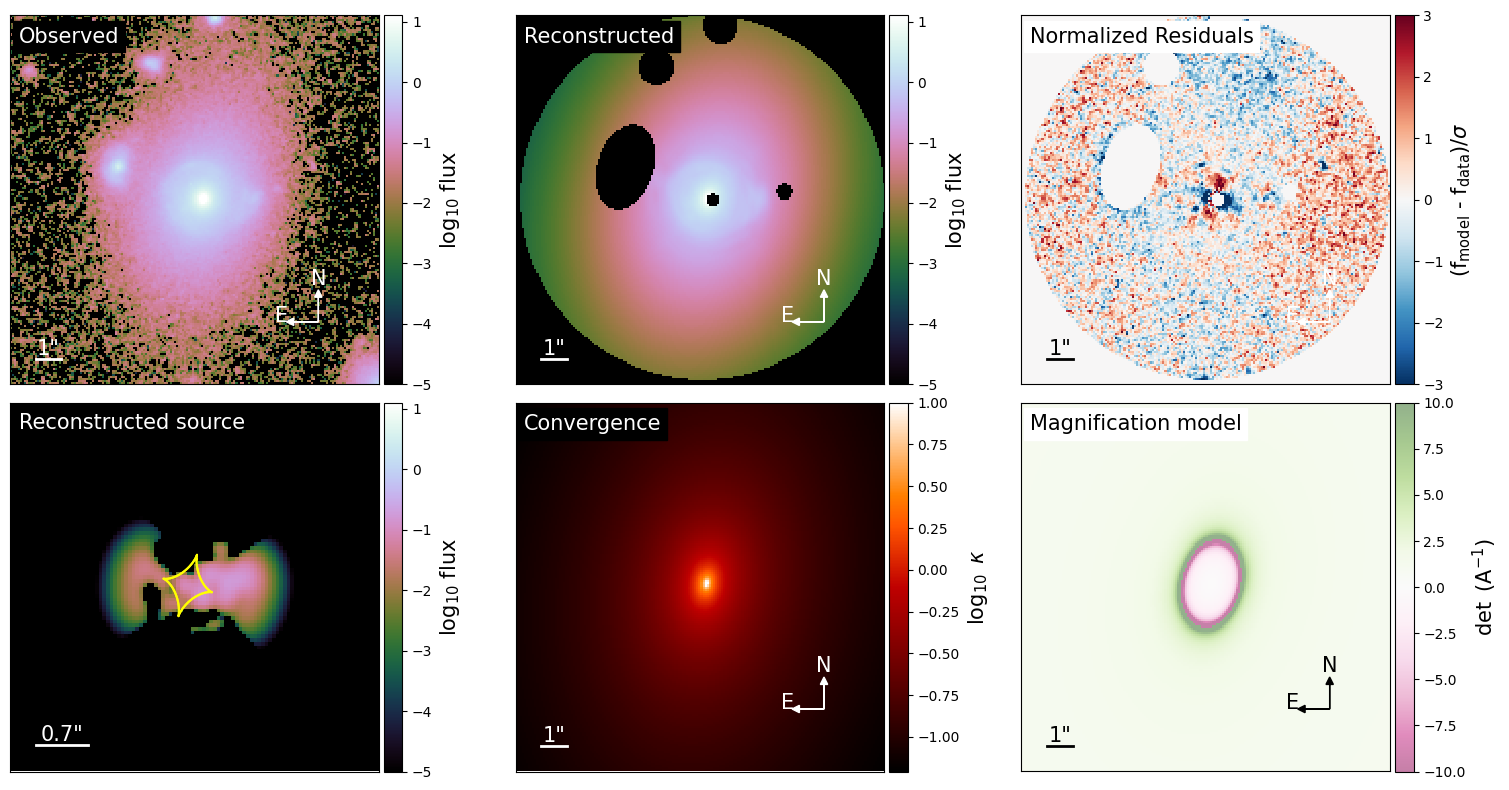

/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:1082: RuntimeWarning: divide by zero encountered in log10
  np.log10(model),
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:1082: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


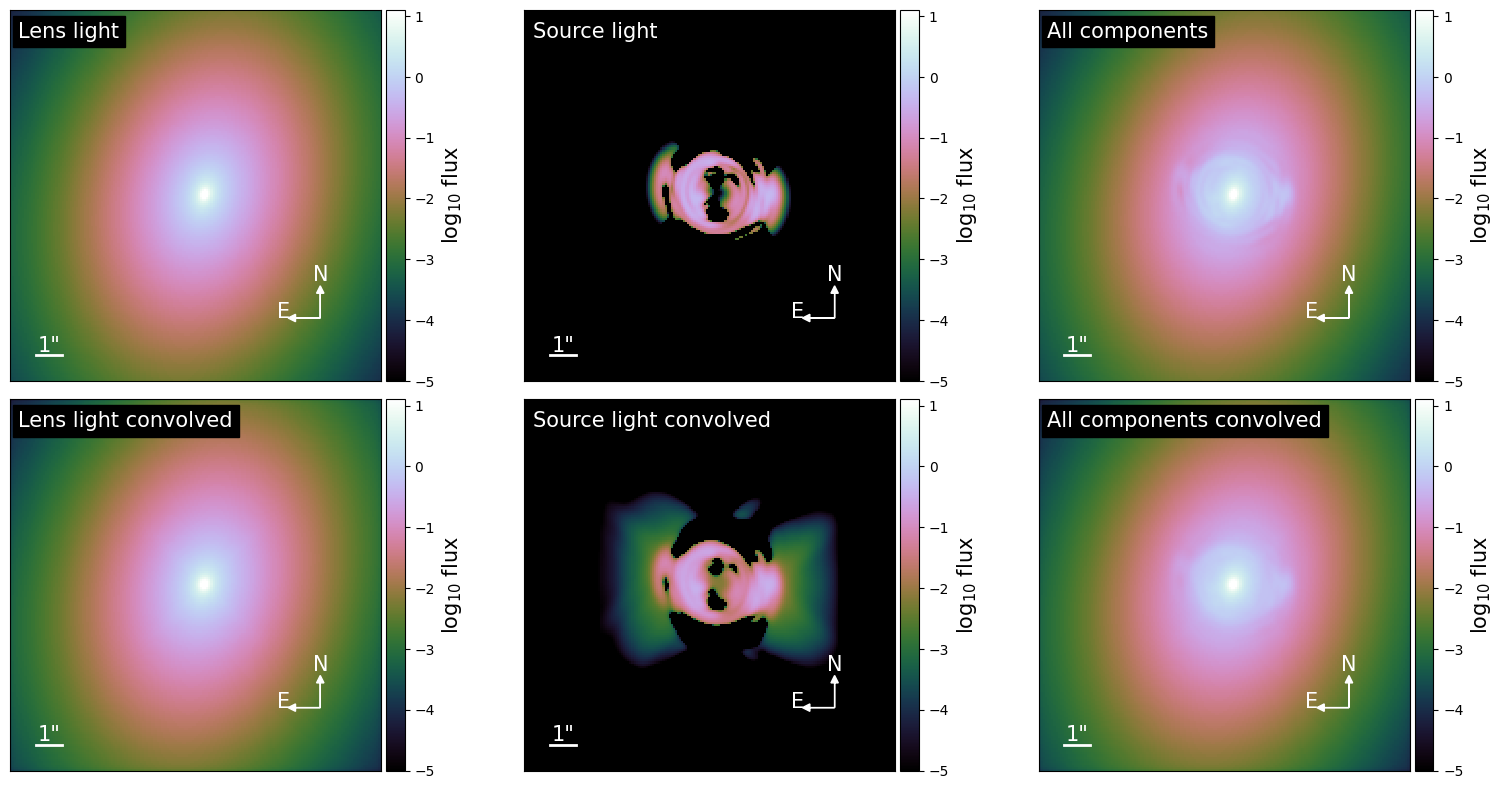

{'kwargs_lens': [{'theta_E': 1.4058796529313429, 'gamma': 2, 'e1': -0.19250512886654447, 'e2': -0.0622101609138281, 'center_x': -0.14787208400598081, 'center_y': 0.040098361264262014}, {'gamma1': -0.013559348645823616, 'gamma2': 0.03171964859475819, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': array([ 7.68575428e+01, -5.36603595e+01, -4.78544609e+00,  4.99222193e+01,
       -1.10792632e+01, -2.23412831e+01, -3.95752752e+01,  1.57257292e+01,
       -3.99528117e+00,  1.30080705e-01,  4.65511091e+01, -9.25262176e+00,
       -8.90837773e-01,  1.56547983e+00, -1.39435365e+01, -3.78646759e+01,
        1.28718263e+01,  8.12299998e+00, -7.99998019e+00,  6.21807007e+00,
       -4.22991846e-01,  3.71219674e+01,  2.37335055e-01, -4.23138293e+00,
        2.14859341e+00, -8.93372230e+00,  5.92796468e+00, -2.28788928e+00,
       -1.46679564e+01,  2.33886257e+01,  6.44878125e+00, -5.00666846e+00,
       -5.74941072e+00,  6.61207354e+00, -9.45523842e+00, -2.66440824e-01,
        1.76404182e+01, 

In [22]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result_mcmc,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.05, numPix=100, with_caustics=True, scale_size=0.7
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

print(kwargs_result_mcmc)

In [23]:
chain.shape

(80, 2202, 16)

## `MCMC` Output

In [24]:
multi_band_list_out = fitting_seq_mcmc.multi_band_list
kwargs_fixed_out = fitting_seq_mcmc.kwargs_fixed

init_samples = n_step  # cannot be 'None' for MCMC

input = [
    fitting_kwargs_list_mcmc,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

# Defining shortened_samples_mcmc
if samples_mcmc is not None:
    print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
    n_sample = len(samples_mcmc)
    print(n_sample)
    burnin = 1950
    thin = 20
    shortened_samples_mcmc = chain[:, burnin::thin, :].reshape((-1, n_params))
    shortened_samples_mcmc = shortened_samples_mcmc[-1000:, :]

print("Shape of shortened_samples_mcmc:", shortened_samples_mcmc.shape)

output = [
    kwargs_result_mcmc,
    multi_band_list_out,
    kwargs_fixed_out,
    shortened_samples_mcmc,
    param_mcmc,
]
output_path = "./DESIJ0132-1600_mcmc_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=9)

Number of evaluations in the MCMC process: 176160
176160
Shape of shortened_samples_mcmc: (1000, 16)


In [25]:
### load mcmc model ###
load_output_path_mcmc = "./DESIJ0132-1600_mcmc_output.joblib"
with open(load_output_path_mcmc, "rb") as f:
    [input_, output_] = joblib.load(f)
    # print("input:\n",input_, "\noutput:\n",output_)
(
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
) = input_
# print(input_)

(
    kwargs_result_mcmc,
    multi_band_list_out,
    kwargs_fixed_out,
    shortened_samples_mcmc,
    param_mcmc,
) = output_
n_params = len(param_mcmc)
print("Shape of shortened_samples_mcmc:", shortened_samples_mcmc.shape)
kwargs_result_mcmc

Shape of shortened_samples_mcmc: (1000, 16)


{'kwargs_lens': [{'theta_E': 1.4058796529313429,
   'gamma': 2,
   'e1': -0.19250512886654447,
   'e2': -0.0622101609138281,
   'center_x': -0.14787208400598081,
   'center_y': 0.040098361264262014},
  {'gamma1': -0.013559348645823616,
   'gamma2': 0.03171964859475819,
   'ra_0': 0,
   'dec_0': 0}],
 'kwargs_source': [{'amp': array([ 7.68575428e+01, -5.36603595e+01, -4.78544609e+00,  4.99222193e+01,
          -1.10792632e+01, -2.23412831e+01, -3.95752752e+01,  1.57257292e+01,
          -3.99528117e+00,  1.30080705e-01,  4.65511091e+01, -9.25262176e+00,
          -8.90837773e-01,  1.56547983e+00, -1.39435365e+01, -3.78646759e+01,
           1.28718263e+01,  8.12299998e+00, -7.99998019e+00,  6.21807007e+00,
          -4.22991846e-01,  3.71219674e+01,  2.37335055e-01, -4.23138293e+00,
           2.14859341e+00, -8.93372230e+00,  5.92796468e+00, -2.28788928e+00,
          -1.46679564e+01,  2.33886257e+01,  6.44878125e+00, -5.00666846e+00,
          -5.74941072e+00,  6.61207354e+00, -9.4552

In [26]:
mcmc_output = joblib.load("DESIJ0132-1600_mcmc_output.joblib")
param_mcmc = mcmc_output[1][4]
print(param_mcmc)

['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'beta_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1']


## Light and Mass ellipticity check after MCMC

In [27]:
result_mass_e1 = kwargs_result_mcmc["kwargs_lens"][0]["e1"]
result_mass_e2 = kwargs_result_mcmc["kwargs_lens"][0]["e2"]

result_light_e1 = kwargs_result_mcmc["kwargs_lens_light"][0]["e1"]
result_light_e2 = kwargs_result_mcmc["kwargs_lens_light"][0]["e2"]

result_mass_gamma1 = kwargs_result_mcmc["kwargs_lens"][1]["gamma1"]
result_mass_gamma2 = kwargs_result_mcmc["kwargs_lens"][1]["gamma2"]

phi_mass, q_mass = ellipticity2phi_q(result_mass_e1, result_mass_e2)
phi_light, q_light = ellipticity2phi_q(result_light_e1, result_light_e2)
phi_shear, gamma_shear = shear_cartesian2polar(result_mass_gamma1, result_mass_gamma2)

print("phi_mass: {}, q_mass: {}".format(phi_mass, q_mass))

print("phi_light: {}, q_light: {}".format(phi_light, q_light))

print("phi_shear: {}, gamma_shear: {}".format(phi_shear, gamma_shear))

phi_mass: -1.4145124568197613, q_mass: 0.6634679420313843
phi_light: -1.3011714376246604, q_light: 0.7120648075323475
phi_shear: 0.9873806177364698, gamma_shear: 0.03449626128544866


## Half-light radius calculation after MCMC

In [28]:
lens_central_model_list = [lens_light_model_list[0], lens_light_model_list[1]]

light_model_central = LightModel(lens_central_model_list)
analysis_central = LightProfileAnalysis(light_model_central)

# Providing the lens light results from MCMC
kwargs_central_light = [
    kwargs_result_mcmc["kwargs_lens_light"][0],
    kwargs_result_mcmc["kwargs_lens_light"][1],
]

# Calculate the half-light radius of central lens
half_light_radius_mcmc = analysis_central.half_light_radius(
    kwargs_central_light, grid_spacing=0.01, grid_num=10 / 0.01
)
# Calculate the total flux of central lens
total_flux_central_mcmc = analysis_central.flux_components(
    kwargs_central_light, grid_spacing=0.01, grid_num=10 / 0.01
)

print("Half-light radius:", half_light_radius_mcmc)
print("Total Central lens flux:", total_flux_central_mcmc)

Half-light radius: 1.0737275050961488
Total Central lens flux: ([1532.1159751092296, 1093.2021326051324], [1.7659991860134026, 0.32494385022646605])


### Uncertainty calculation for the $\theta_E$, $\gamma$, and center coordinates of the lens Galaxy

In [29]:
# The list of parameters to be included in the yaml file without conversion
list_params = [
    "theta_E_lens0",
    "gamma_lens0",
    "center_x_lens0",
    "center_y_lens0",
    "center_x_lens_light0",
    "center_y_lens_light0",
]

# Uncertainty calculation
median_sample = np.zeros(n_params)
q16_sample = np.zeros(n_params)
q84_sample = np.zeros(n_params)
values = {}

for i in range(n_params):
    median_sample[i] = np.median(shortened_samples_mcmc[:, i])
    q16_sample[i] = np.percentile(shortened_samples_mcmc[:, i], 16.0)
    q84_sample[i] = np.percentile(shortened_samples_mcmc[:, i], 84.0)

    values[param_mcmc[i]] = [
        median_sample[i],
        q84_sample[i] - median_sample[i],
        median_sample[i] - q16_sample[i],
    ]
# parameters filtered by list params
parameter_values = {k: values.get(k) for k in list_params}

# renaming parameters
parameter_values["theta_E"] = parameter_values.pop("theta_E_lens0")
parameter_values["gamma"] = parameter_values.pop("gamma_lens0")
parameter_values["center_x_mass"] = parameter_values.pop("center_x_lens0")
parameter_values["center_y_mass"] = parameter_values.pop("center_y_lens0")
parameter_values["center_x_light"] = parameter_values.pop("center_x_lens_light0")
parameter_values["center_y_light"] = parameter_values.pop("center_y_lens_light0")

parameter_values["gamma"] = 2  # value of gamma is kept fixed at 2.0 for the mcmc run

# adding Half-light Radius
parameter_values["R_eff_light"] = half_light_radius_mcmc

print("\n", parameter_values)  # ['theta_E_lens0'][0])


 {'theta_E': [1.4033769754830199, 0.00543287573108131, 0.006042374005847284], 'gamma': 2, 'center_x_mass': [-0.15032479934314613, 0.008177262726212942, 0.008550396486018214], 'center_y_mass': [0.042365859903189584, 0.008422831039315494, 0.008776861594015799], 'center_x_light': [-0.26212354922562187, 0.0007435977978409447, 0.0007240448745162165], 'center_y_light': [-0.05219499851711493, 0.000635407599623182, 0.0006158441783892452], 'R_eff_light': 1.0737275050961488}


In [30]:
list_params_prior = [
    "e1_lens0",
    "e2_lens0",
    "gamma1_lens1",
    "gamma2_lens1",
    "e1_lens_light0",
    "e2_lens_light0",
]

list_params_posterior = [
    "phi_mass",
    "q_mass",
    "phi_shear",
    "gamma_shear",
    "phi_light",
    "q_light",
]
n_params_prior = len(list_params_prior)
n_params_posterior = len(list_params_posterior)
length_shortened = len(shortened_samples_mcmc)

prior_samples = np.zeros((length_shortened, n_params_prior))

# Copying the selected (prior) parameters from shortened samples
for j in list_params_prior:
    if j in param_mcmc:
        prior_samples[:, list_params_prior.index(j)] = shortened_samples_mcmc[
            :, param_mcmc.index(j)
        ]
    else:
        print(f"Warning: Parameter '{j}' not found in param_mcmc.")


# Initializing an array for saving the converted parameter values
posterior_samples = np.zeros((length_shortened, n_params_posterior))

for i in range(0, n_params_posterior, 2):
    if i == 0 or i == 4:
        for j in range(length_shortened):
            (
                posterior_samples[j][i],
                posterior_samples[j][i + 1],
            ) = ellipticity2phi_q(prior_samples[j][i], prior_samples[j][i + 1])
    elif i == 2:
        for k in range(length_shortened):
            (
                posterior_samples[k][i],
                posterior_samples[k][i + 1],
            ) = shear_cartesian2polar(prior_samples[k][i], prior_samples[k][i + 1])
            # print(posterior_samples[k][i], posterior_samples[k][i+1])
    else:
        print("Array Index Out of Range")

# Uncertainty calculation
median_sample_posterior = np.zeros(n_params_posterior)
q84_sample_posterior = np.zeros(n_params_posterior)
q16_sample_posterior = np.zeros(n_params_posterior)

values_posterior = {}


for i in range(n_params_posterior):
    median_sample_posterior[i] = np.median(posterior_samples[:, i])
    q16_sample_posterior[i] = np.percentile(posterior_samples[:, i], 16.0)
    q84_sample_posterior[i] = np.percentile(posterior_samples[:, i], 84.0)

    values_posterior[list_params_posterior[i]] = [
        median_sample_posterior[i],
        q84_sample_posterior[i] - median_sample_posterior[i],
        median_sample_posterior[i] - q16_sample_posterior[i],
    ]
# print(values_posterior)
# marge previous parameters and new converted parameters
parameter_values.update(values_posterior)
print(parameter_values)

{'theta_E': [1.4033769754830199, 0.00543287573108131, 0.006042374005847284], 'gamma': 2, 'center_x_mass': [-0.15032479934314613, 0.008177262726212942, 0.008550396486018214], 'center_y_mass': [0.042365859903189584, 0.008422831039315494, 0.008776861594015799], 'center_x_light': [-0.26212354922562187, 0.0007435977978409447, 0.0007240448745162165], 'center_y_light': [-0.05219499851711493, 0.000635407599623182, 0.0006158441783892452], 'R_eff_light': 1.0737275050961488, 'phi_mass': [-1.3707276003598923, 0.043108332863802445, 0.045317355445170904], 'q_mass': [0.6756192379141153, 0.022684585476891228, 0.020146784571489107], 'phi_shear': [0.9125793469223656, 0.14944192193208183, 0.14893299993266507], 'gamma_shear': [0.026462004283037875, 0.008948049674145336, 0.008403511220754126], 'phi_light': [-1.299158465714335, 0.003517818469326528, 0.003936505340702334], 'q_light': [0.7133465371810312, 0.002368498007993547, 0.0020666879345638822]}


## Creating the YAML file

In [31]:
# make all the numpy variables float
parameter_values = {
    key: [float(item) if item is not None else None for item in value]
    if isinstance(value, list)
    else float(value)
    if value is not None
    else None
    for key, value in parameter_values.items()
}

# Write the dictionary to a YAML file
yaml_file_name = "/content/drive/MyDrive/BDLensing/DESIJ0132-1600_point_estimates.yml"
with open(yaml_file_name, "w") as yaml_file:
    yaml.dump(parameter_values, yaml_file, default_flow_style=False)

print(f"YAML file '{yaml_file_name}' created successfully.")
print(parameter_values)

YAML file '/content/drive/MyDrive/BDLensing/DESIJ0132-1600_point_estimates.yml' created successfully.
{'theta_E': [1.4033769754830199, 0.00543287573108131, 0.006042374005847284], 'gamma': 2.0, 'center_x_mass': [-0.15032479934314613, 0.008177262726212942, 0.008550396486018214], 'center_y_mass': [0.042365859903189584, 0.008422831039315494, 0.008776861594015799], 'center_x_light': [-0.26212354922562187, 0.0007435977978409447, 0.0007240448745162165], 'center_y_light': [-0.05219499851711493, 0.000635407599623182, 0.0006158441783892452], 'R_eff_light': 1.0737275050961488, 'phi_mass': [-1.3707276003598923, 0.043108332863802445, 0.045317355445170904], 'q_mass': [0.6756192379141153, 0.022684585476891228, 0.020146784571489107], 'phi_shear': [0.9125793469223656, 0.14944192193208183, 0.14893299993266507], 'gamma_shear': [0.026462004283037875, 0.008948049674145336, 0.008403511220754126], 'phi_light': [-1.299158465714335, 0.003517818469326528, 0.003936505340702334], 'q_light': [0.7133465371810312, 0

In [32]:
# Read the YAML file using safe_load

with open(yaml_file_name, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 13
{'R_eff_light': 1.0737275050961488, 'center_x_light': [-0.26212354922562187, 0.0007435977978409447, 0.0007240448745162165], 'center_x_mass': [-0.15032479934314613, 0.008177262726212942, 0.008550396486018214], 'center_y_light': [-0.05219499851711493, 0.000635407599623182, 0.0006158441783892452], 'center_y_mass': [0.042365859903189584, 0.008422831039315494, 0.008776861594015799], 'gamma': 2.0, 'gamma_shear': [0.026462004283037875, 0.008948049674145336, 0.008403511220754126], 'phi_light': [-1.299158465714335, 0.003517818469326528, 0.003936505340702334], 'phi_mass': [-1.3707276003598923, 0.043108332863802445, 0.045317355445170904], 'phi_shear': [0.9125793469223656, 0.14944192193208183, 0.14893299993266507], 'q_light': [0.7133465371810312, 0.002368498007993547, 0.0020666879345638822], 'q_mass': [0.6756192379141153, 0.022684585476891228, 0.020146784571489107], 'theta_E': [1.4033769754830199, 0.00543287573108131, 0.006042374005847284]}


### Reloading using $\Sigma_{10}$, $\Sigma_{10,\text{flux selected}}$ , $\Sigma_{20}$, $\Sigma_{20,\text{flux selected}}$ values

In [33]:
# Read the YAML file using safe_load

existing_yaml_file = (
    "/content/drive/MyDrive/BDLensing/DESIJ0132-1600_point_estimates.yml"
)

with open(existing_yaml_file, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 13
{'R_eff_light': 1.0737275050961488, 'center_x_light': [-0.26212354922562187, 0.0007435977978409447, 0.0007240448745162165], 'center_x_mass': [-0.15032479934314613, 0.008177262726212942, 0.008550396486018214], 'center_y_light': [-0.05219499851711493, 0.000635407599623182, 0.0006158441783892452], 'center_y_mass': [0.042365859903189584, 0.008422831039315494, 0.008776861594015799], 'gamma': 2.0, 'gamma_shear': [0.026462004283037875, 0.008948049674145336, 0.008403511220754126], 'phi_light': [-1.299158465714335, 0.003517818469326528, 0.003936505340702334], 'phi_mass': [-1.3707276003598923, 0.043108332863802445, 0.045317355445170904], 'phi_shear': [0.9125793469223656, 0.14944192193208183, 0.14893299993266507], 'q_light': [0.7133465371810312, 0.002368498007993547, 0.0020666879345638822], 'q_mass': [0.6756192379141153, 0.022684585476891228, 0.020146784571489107], 'theta_E': [1.4033769754830199, 0.00543287573108131, 0.006042374005847284]}
